In [1]:
import numpy as np 
import scipy.optimize as opt
import matplotlib.pyplot as plot
import os

In [24]:
def load_data(file_ID, date):
    # Create folder and file name
    folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Thermometry\\'
    
    file_name = folder_path + date + '\\' + file_ID 
    print(file_name)
    # Load data from file and perfrom a mean of the value. 
    data = np.loadtxt(file_name + '.dat')
    
    mean_data = np.mean(data, axis=0)
    # load data from params file. 
    params_file = folder_path + date + '\\'  + file_ID + 'Params' + '.dat'
    params = np.loadtxt(params_file, delimiter = '\t', usecols = 1)
    start = params[0]
    stop = params[1]
#    step = params[2]*0.001
    no_of_steps = len(mean_data)
   
    # Creates a variable containing the applied frequencies. 
    if start < stop:
        freq = np.linspace(start, stop, no_of_steps)
    else:
        freq = np.linspace(stop, start, no_of_steps)
        mean_data = mean_data[::-1]
        
    #mean_data = mean_data/(np.max(mean_data))
        
    return(freq, mean_data, data)   

In [3]:
def scatter_plot(freq,mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig, ax = plot.subplots()
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax.scatter(freq, mean_data, marker = 'x',color = 'r', label = "Experiment Data")
    
    return(fig, ax)

In [4]:
def Analysis(freq, mean_data):    
    end_point = int(len(mean_data))
    #   Determines the mean fluorescenet baseline signal. 
    fluor_baseline = np.mean(mean_data[int(np.floor(0.9*end_point)):end_point])
    fluor_min = np.min(mean_data)

    # First guesses for the curve fittings
    A = (fluor_min-fluor_baseline)
    x0 = 2.85
    gamma = 0.01
    offset = fluor_baseline
    A2 = (fluor_min-fluor_baseline)
    x02 = 2.88
    gamma2 = 0.01
    

#    P1 = [A, x0, gamma, offset]
    P2 = [A, x0, gamma, A2, x02, gamma2, offset]
    P2 = np.array(P2)
   # y2 = gaussian_2(freq, A, x0, gamma, A2, x02, gamma2, offset)
   # plot.plot(freq, y2, color = 'g')
   
#    x, y, opt_error, contrast, contrast_error = single_peak(freq, mean_data, P1)
    analysis = multi_peak(freq, mean_data, P2)
    print(type(P2))
    return(analysis)

In [5]:
def single_peak(freq, mean_data, P1):
    # Apply curve fitting optimisation 
#    coeffs, confidence = opt.curve_fit(gaussian, freq, mean_data, P1)    
    coeffs, confidence = opt.curve_fit(lorentz, freq, mean_data, P1)
    opt_error = np.sqrt(np.diag(confidence))
    
    x = np.linspace(np.min(freq), np.max(freq), 1000)
    # Generate fit. 
#    y = gaussian(x, coeffs[0], coeffs[1], coeffs[2], coeffs[3])
    y = lorentz(x, coeffs[0], coeffs[1], coeffs[2], coeffs[3])  
    
    contrast = (1-(np.min(mean_data)/coeffs[4]))*100
    contrast_error = (np.sqrt(coeffs[4])/coeffs[4])*contrast

    return(x, y, coeffs, opt_error, contrast, contrast_error)

In [6]:
def multi_peak(freq, mean_data, P2):
    # Apply curve fitting optimisation 
#    coeffs, confidence = opt.curve_fit(gaussian_2, freq, mean_data, P0)
    coeffs, confidence = opt.curve_fit(lorentz_2, freq, mean_data, P2)
    opt_error = np.sqrt(np.diag(confidence))
    
    x = freq #np.linspace(np.min(freq), np.max(freq), 1000)
    #y = gaussian_2(x, coeffs[0], coeffs[1], coeffs[2], coeffs[3],coeffs[4], coeffs[5], coeffs[6])
    
    
    y = lorentz_2(x, coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6])
    print('res freqs: ' + str(coeffs[4]), str(coeffs[1]))
    #caculate applied B field\zero field splitting        
    hbar = 6.62*10**(-34)
    MuB = 9.24*10**(-24)
    ge = 2.002  
    
    splitting = (coeffs[4]-coeffs[1])*1000 
    print('splitting: ' + str(splitting))
    B_Field = (splitting*10**6*hbar)/(2*ge*MuB)
    #print(B_Field)
    
    contrast = (1-(np.min(mean_data)/coeffs[6]))*100
    contrast_error = (np.sqrt(coeffs[6])/coeffs[6])*contrast
    print('contrast; ' + str(contrast))
    return([x, y, coeffs, opt_error, splitting, B_Field, contrast, contrast_error])

In [7]:
def plot_fitting(ax, x, y):    
    #Plot  fit and complete graph
    plot.plot(x,y, color = 'k', linewidth = 2.0, label = "Double Lorentzian curve fitting")
    ax.set_xlabel('Microwave Frequency  (GHz)')
    ax.set_ylabel('Counts (per int. time)')
    #axes = plot.gca()
    ax.set_xlim(np.min(x), np.max(x))
#    axes.set_ylim(0.985*np.min(y), 1.02*np.max(y))
    ax.legend(loc = 'lower right')
    return(ax)

In [8]:
def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset  

In [9]:
def gaussian_2(x, height, center, width, height2, center2, width2, offset):
    # P0[0] = Amplitude 1, P0[1] = Resonance 1, P0[2] = FWHM 1
    # P0[3] = Amplitude 2, P0[4] = Resonance 2, P0[5] = FWHM 2, P0[6] = offset
    
    first_peak = height*np.exp(-(x - center)**2/(2*width**2))
    second_peak = height2*np.exp(-(x - center2)**2/(2*width2**2)) 
    return first_peak + second_peak + offset 


In [10]:
def lorentz(x, A, x0, gamma, D):
    return (A/np.pi) *(gamma/((x-x0)**2)+gamma**2) + D


In [11]:
def lorentz_2(x, A1, X01, sig1, A2, X02, sig2, offset):#P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # P0[0] = Amplitude 1, P0[1] = Resonance 1, P0[2] = FWHM 1
    # P0[3] = Amplitude 2, P0[4] = Resonance 2, P0[5] = FWHM 2, P0[6] = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return first_peak + second_peak + offset


In [12]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In [13]:
def save_data(date, file_ID, contrast, contrast_error, coeffs, opt_error, r_squared):
    
    destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\Thermometry\\' + date + '\\'
    output_data_file = destination_folder + date + '_NVScan_analysis.dat'
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name' +  ', \t' + 'Max Contrast (%)' + '\t' + 'Contrast error (%)' + '\t' + 
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 'R^2 for fitting' +'\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID + ' \t' +  str(contrast) + " \t"  + str(contrast_error) +
                 " \t"  + str(coeffs[1]) + " \t"  + str(opt_error[1]) +
                 " \t" +  str(coeffs[2]*1000) + " \t" + str(opt_error[2]*1000) + 
                 " \t"  + str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
                 str(coeffs[5]*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
                 str(r_squared) + '\n')
    # Saving a plot of the raw data to a folder. 
    plot.savefig(destination_folder + file_ID + '.pdf', transparent = True)    
    plot.savefig(destination_folder + file_ID + '.png', transparent = True) 
  

The Following code is the "master" control for the lorentz fitting for the ODMR data. 

I:\Science\Physics-Nanobiophotonics\Group\User Data\ODMR\Thermometry\20200918\20200918_NVScan_01
res freqs: 2.8830690690655447 2.8404044880600283
splitting: 42.664581005516396
contrast; 13.205841597030588
<class 'numpy.ndarray'>
R^2 = 0.8508458214807284


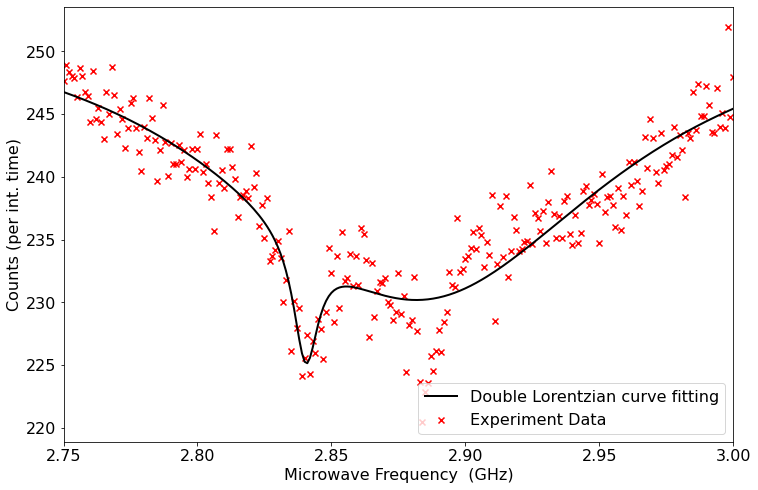

In [25]:
date = '20200918'
fileID = date + '_NVScan' + '_01'
freq, mean_data, data = load_data(fileID, date)
fig, ax = scatter_plot(freq, mean_data)
analysis = Analysis(freq, mean_data)
plot_fitting(ax, analysis[0], analysis[1])
r_squared = get_r_squared(freq, mean_data, analysis[1])
print('R^2 = ' + str(r_squared))
#save_data(date, fileID, analysis[6], analysis[7], analysis[2], analysis[3], r_squared)  

All of the code written above is designed to plot the ODMR dataset and fit a Lorentzian/Gaussian curve shape to the graph. 

The following code is designed to use this curve-fit to find the frequency points that can be used for 4 point thermomerty. 

The process of 4 point theremometry is outlined in the paper from Fuijiwara et al, entitled "Real-time nanodiamond thermometry probing in-vivo thermogenic responses" which can be found using the following hyperlink: 
<https://advances.sciencemag.org/content/6/37/eaba9636.full>

The steps for this process are: 
1. Identify the "linear" portion of the outer lines of the lorentzian dip fitting. 
2. Create a linear fit describing this area of the curve. 
3. Find the mean fluorescence value for the linear portion of the straight line.
4. Find the frequency values that correspond to the value from part 3 for both the stright lines identified in 1. 
5. Select a frequency step that will be used to identiy the 4 frequency points used for 4 point theromoetry. 
6. Subtract and add the frequency step to the two mean frequnecies identified in 4 to generate the 4 frequnecy points. 

In [16]:
def find_fitting_minima(res_freq1, res_freq2, frequency):
    # This function finds the positions of the two minima from the curve fitting frequnecy array as a 
    # position in the array.
    
    minima_pos = []
    
    minima_pos.append( np.where(frequency == res_freq1) )
    minima_pos.append( np.where(frequency == res_freq2) )
    minima_pos = np.array(minima_pos)
    
    return(minima_pos)

In [17]:
def straight_lines(curve_fitting, minima_position):
    # This function is used to find the straight line portions of the curve fitting. 
    maxima = np.max(curve_fitting)
    minima = np.min(curve_fitting)
    limits = [0.98*maxima, 1.003*minima]
    straight_line = []
    
    for i in range(len(curve_fitting)):
        if curve_fitting[i] < limits[0]:
            if curve_fitting[i] > limits[1]:
                straight_line.append(i)
    
    return(straight_line)
    

In [18]:
def linear_fit(freq, m, c):
    # linear fitting. 
    y = m*freq + c
    return(y)

In [19]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In [20]:
def get_4_freq_indicies(linear_fit):
    # This is the method to find the index in the lienar fits for the
    # 4 frequency points to be used for 4 point thermometry. 
    
    array_length = len(linear_fit)
    
    mid_point = np.floor(array_length/2) 
    delta_f_index = np.floor(array_length/4) 
    
    f_minus = int(mid_point-delta_f_index)
    f_plus = int(mid_point+delta_f_index)
    f_mid = mid_point
    
    return(f_mid, f_minus, f_plus)
    

In [21]:
def plot_4_points(freq, curve_fitting, low_linear_freq, low_f_linear_fit, high_linear_freq, high_f_linear_fit, f_array, y_array):
    # Plot the curve fitting and the 4 frequency points
    fig, ax = plot.subplots()

    plot.plot(freq, curve_fitting, color = 'k', label = 'Lorentz curve fitting', linestyle = '--')
    plot.plot(low_linear_freq, low_f_linear_fit, color = 'r', label = 'linear fitting')
    plot.plot(high_linear_freq, high_f_linear_fit, color = 'r')

    plot.scatter(f_array, y_array, marker = 'x', color = 'k', label = '4 frequency points')
    plot.legend()
    return(fig, ax)

In [3]:
def save_4_point_fitting_data(date, file_ID, fitting_low_f, fitting_high_f, dw, f_array, deltaI, fig):
        
    destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\Thermometry\\' + date + '\\'
    output_data_file = destination_folder + file_ID + '_4_point_thermometry_fitting.dat'
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    with open(output_data_file, "w") as wf:
        wf.write('4 point thermometry initial data' + '\n'
                 + 'File name' + '\t' + file_ID + '.dat' + '\n'
                 + 'Low freq linear fitting gradient (counts/GHz)' + '\t' +  str(fitting_low_f[0]) + '\n'
                 + 'error Low freq linear fitting gradient (normalised counts/GHz)' + '\t' + str(fitting_low_f[1]) + '\n'
                 + 'Low freq linear fitting y intercept (normalised counts/GHz)' + '\t' + str(fitting_low_f[2]) + '\n'
                 + 'error Low freq linear fitting y intercept (normalised counts/GHz)' + '\t' + str(fitting_low_f[3]) + '\n'
                 + 'Low frequency fitting r^2' + '\t' + str(fitting_low_f[4]) + '\n'
                 + 'High freq linear fitting gradient (counts/GHz)' + '\t' +  str(fitting_high_f[0]) + '\n'
                 + 'error High freq linear fitting gradient (normalised counts/GHz)' + '\t' + str(fitting_high_f[1]) + '\n'
                 + 'high freq linear fitting y intercept (normalised counts/GHz)' + '\t' + str(fitting_high_f[2]) + '\n'
                 + 'error high freq linear fitting y intercept (normalised counts/GHz)' + '\t' + str(fitting_high_f[3]) + '\n'
                 + 'high frequency fitting r^2' + '\t' + str(fitting_high_f[4]) + '\n'
                 + 'Delta Omega (GHz)' + '\t' + str(dw) + '\n'
                 + 'f1 (GHz)' + '\t' + str(f_array[0]) + '\n'
                 + 'f2 (GHz)' + '\t' + str(f_array[1]) + '\n'
                 + 'f3 (GHz)' + '\t' + str(f_array[2]) + '\n'
                 + 'f4 (GHz)' + '\t' + str(f_array[3]) + '\n'
                 + 'F_off_res_signal (GHZ)' + '\t' + '2.75GHz' + '\n'
                 + 'Delta I from 4 freqeuncy points (normailised counts)' + '\t' + str(deltaI) + '\n'
            
          )
    # Saving a plot of the raw data to a folder. 
    plot.savefig(destination_folder + '4 point thermometry fitting ' + file_ID  + '.pdf', transparent = True)    
    plot.savefig(destination_folder + '4 point thermometry fitting ' + file_ID + '.png', transparent = True) 
  
    

The following code is used to find the 4 frequency points to be used for 4 point thermometry. 

[2.843, 2.847, 2.878, 2.882]
[0.9724063882735798, 0.9541700935339712, 0.9549778618018223, 0.9728690783159202]


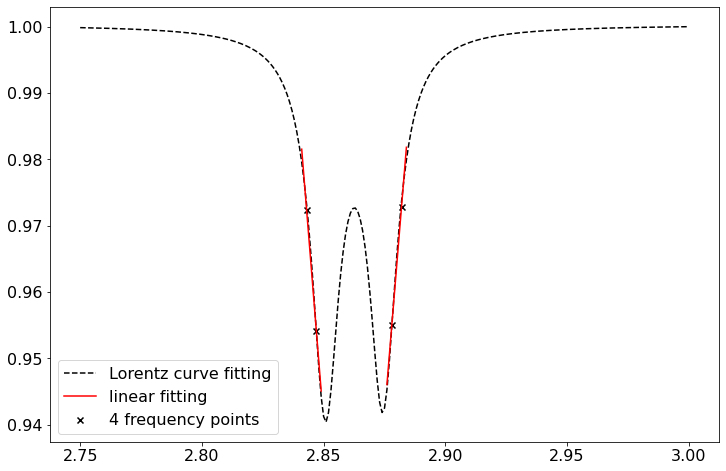

In [23]:
# Find the indexs that correspond the minima of the curve fitting.= and convert this into an array.
minima_positions = find_fitting_minima(np.round(analysis[2][1],3), np.round(analysis[2][4],3), analysis[0]) 
minima_pos = [minima_positions[0][0][0], minima_positions[1][0][0]]

# Get the curve fitting values into a new variable and normalise
curve_fitting = analysis[1]
curve_fitting = curve_fitting/(np.max(curve_fitting))

# Find the portions of the curve fitting that are in the linear portion of the ODMR dips.  
straight_line_lowF = straight_lines(curve_fitting[0:minima_pos[0]], minima_pos[0])
straight_line_highF = straight_lines(curve_fitting[minima_pos[1]:len(curve_fitting)-1], minima_pos[1]) + minima_pos[1]

# Stright line fit first guesses
initial_params = [1,1]

# find the parameters for a straight line fitting for the high and low frequency linear portion
# of the lorentz curve fitting
low_f_linear_fit_coeffs, confidence_lowf = opt.curve_fit(linear_fit, freq[straight_line_lowF], 
                                                         curve_fitting[straight_line_lowF], initial_params)
opt_error_lowf = np.sqrt(np.diag(confidence_lowf))

high_f_linear_fit_coeffs, confidence_highf  = opt.curve_fit(linear_fit, freq[straight_line_highF ], 
                                  curve_fitting[straight_line_highF], initial_params)
opt_error_highf = np.sqrt(np.diag(confidence_highf))

# Create the linear fits
low_f_linear_fit = linear_fit(freq[straight_line_lowF], low_f_linear_fit_coeffs[0], low_f_linear_fit_coeffs[1])
high_f_linear_fit = linear_fit(freq[straight_line_highF], high_f_linear_fit_coeffs[0], high_f_linear_fit_coeffs[1])

# Create linear fit frequency arrays
low_linear_freq = freq[straight_line_lowF]
high_linear_freq = freq[straight_line_highF]

#Check the quality of the fitting
low_f_r_squared = get_r_squared(freq[straight_line_lowF], curve_fitting[straight_line_lowF], low_f_linear_fit )
high_f_r_squared = get_r_squared(freq[straight_line_highF], curve_fitting[straight_line_highF], high_f_linear_fit )

#get the indicies for the 4 frequency points used for thermometry.
low_f_indicies = get_4_freq_indicies(low_f_linear_fit)
high_f_indicies = get_4_freq_indicies(high_f_linear_fit)

# print the 4 frequnecies to be used during 4 point thermometry.
f1 = low_linear_freq[low_f_indicies[1]]
f2 = low_linear_freq[low_f_indicies[2]]
f3 = high_linear_freq[high_f_indicies[1]]
f4 = high_linear_freq[high_f_indicies[2]]
f_array = [f1, f2, f3, f4]
print(f_array)

# Find the associated y values with the 4 frequency points. 
y1 = low_f_linear_fit[low_f_indicies[1]]
y2 = low_f_linear_fit[low_f_indicies[2]]
y3 = high_f_linear_fit[high_f_indicies[1]]
y4 = high_f_linear_fit[high_f_indicies[2]]
y_array = [y1, y2, y3, y4]
print(y_array)

fig, ax = plot_4_points(freq, curve_fitting, low_linear_freq, low_f_linear_fit, 
                        high_linear_freq, high_f_linear_fit, f_array, y_array)

# Create arrays ready for saving data
fitting_low_f = [low_f_linear_fit_coeffs[0], opt_error_lowf[0], low_f_linear_fit_coeffs[1], opt_error_lowf[1], low_f_r_squared]
fitting_high_f = [high_f_linear_fit_coeffs[0], opt_error_highf[0], high_f_linear_fit_coeffs[1], opt_error_highf[1], high_f_r_squared]
dw = (f2-f1)/2 # frequency difference between the 2 frequnecy points and the middle frequnecy 
deltaI = ((y1+y2) - (y3+y4))/((y1-y2)-(y3-y4))

#save_4_point_fitting_data(date, fileID, fitting_low_f, fitting_high_f, dw, f_array, deltaI, fig)